In [1]:
import os
import sys
sys.path.append("../../../..")
from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import get_model_rocs, allign_metrics, report_alligned_metrics
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict, plot_losses
from nebula.models.attention import TransformerEncoderChunks
from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, *[".."]*4)
import numpy as np
import pickle
RUN_TYPES = ["step", "triangular", "onecycle", "cosine", "none"]
RUN_NAME = "learning rate schedulers"

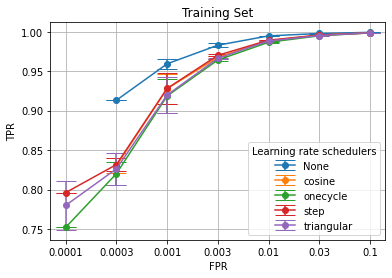

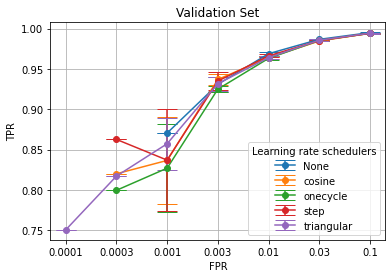

In [2]:
folder = "."
training_files = [x for x in os.listdir(folder) if x.endswith("training.json")]
validation_files = [x for x in os.listdir(folder) if x.endswith("validation.json")]

def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[2]

metrics_train = read_cv_metrics_folder('.', key_extractor, training_filter)
metrics_val = read_cv_metrics_folder('.', key_extractor, validation_filter)

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [3]:
model_config = {
    "vocab_size": 50002,
    "maxlen": 512,
    "chunk_size": 64,
    "dModel": 64,
    "nHeads": 8,
    "dHidden": 256,
    "nLayers": 2,
    "numClasses": 1,
    "hiddenNeurons": [
        64
    ],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False
}

data_splits = read_cv_data_splits("../learning_rates_limit_None_1677580013/")

existing_pickle = os.path.join(folder, "roc_metrics_val.pkl")
if os.path.exists(existing_pickle):
    roc_metrics_val = pickle.load(open(existing_pickle, "rb"))
else:
    roc_metrics_val = get_model_rocs(
        run_types=RUN_TYPES,
        model_class=TransformerEncoderChunks,
        model_config=model_config,
        data_splits=data_splits,
    )
    pickle.dump(roc_metrics_val, open(existing_pickle, "wb"))

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(roc_metrics_val)

,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC
step,0.628000,0.761113,0.872119,0.932818,0.966125,0.985579,0.994286,0.998814,0.997509
triangular,0.503225,0.690559,0.868816,0.928542,0.963830,0.985326,0.994384,0.998776,0.997443
onecycle,0.505630,0.624834,0.858378,0.925331,0.962567,0.985015,0.994189,0.998795,0.997345
cosine,0.538322,0.667607,0.859255,0.929453,0.962918,0.984607,0.994228,0.998795,0.997399
none,0.495966,0.686241,0.845187,0.933179,0.968726,0.986958,0.994888,0.998795,0.997613


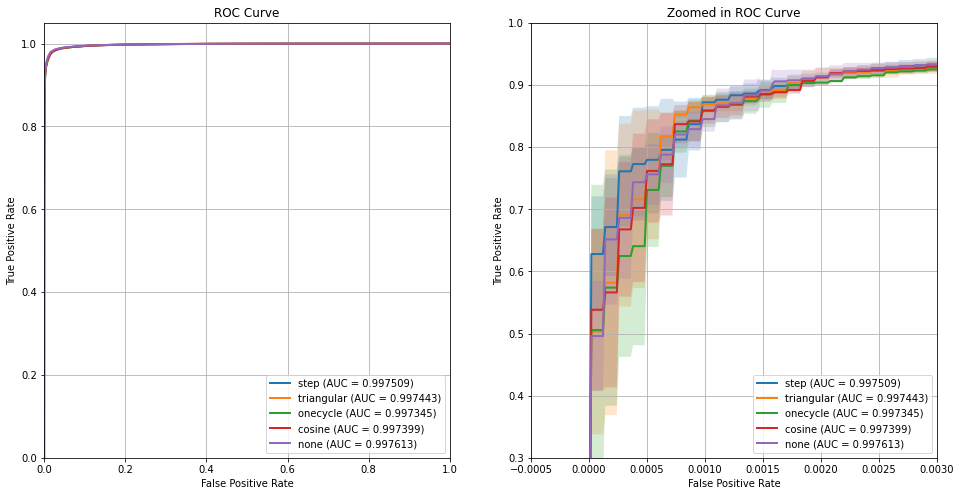

In [4]:
df, axs_val = report_alligned_metrics(base_fpr_val, tprs_mean_val, tprs_std_val, roc_metrics_val, xlim=[-0.0005, 0.003], ylim=[0.3, 1.0])
df

## Test set ROCs

In [5]:
xtestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_vocab_size_50000_maxlen_512_x.npy")
X_test = np.load(xtestpath)
ytestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_y.npy")
y_test = np.load(ytestpath)

splits = 3
data_splits = [{"X_test": X_test, "y_test": y_test}]*splits

existing_pickle = os.path.join(folder, "roc_metrics_test.pkl")
if os.path.exists(existing_pickle):
    metrics = pickle.load(open(existing_pickle, "rb"))
else:
    metrics = get_model_rocs(
        run_types=RUN_TYPES,
        model_class=TransformerEncoderChunks,
        model_config=model_config,
        data_splits=data_splits,
    )
    pickle.dump(metrics, open(existing_pickle, "wb"))

base_fpr, tprs_mean, tprs_std = allign_metrics(metrics)

,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC
step,0.246269,0.368145,0.532844,0.641781,0.738240,0.842852,0.898968,0.957531,0.963603
triangular,0.193910,0.328016,0.562799,0.638626,0.735368,0.840272,0.898011,0.958205,0.963809
onecycle,0.166472,0.331774,0.514446,0.621256,0.711333,0.826549,0.895565,0.959091,0.962949
cosine,0.223191,0.343047,0.531532,0.649793,0.742954,0.834450,0.896664,0.957425,0.963224
none,0.099224,0.384452,0.550640,0.656634,0.754511,0.839413,0.889078,0.959268,0.962059


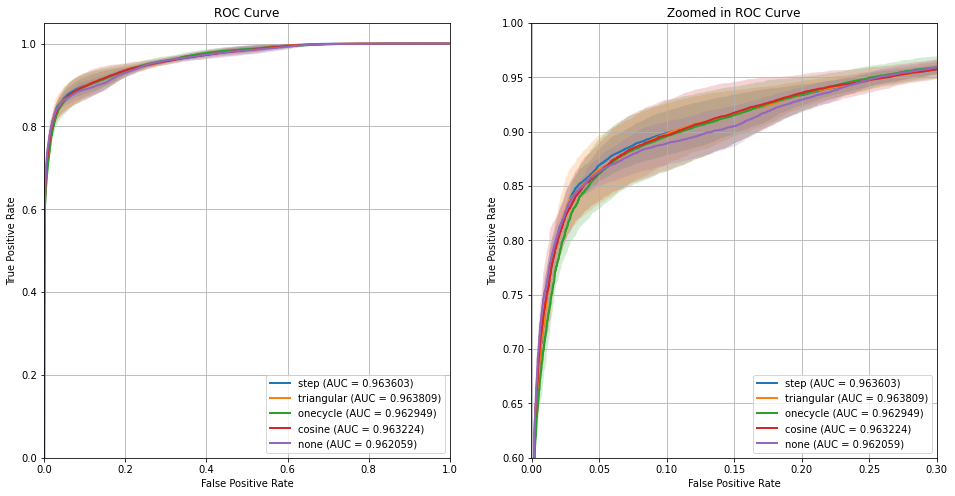

In [6]:
df, axs_test = report_alligned_metrics(base_fpr, tprs_mean, tprs_std, metrics)
df

c:\Users\dtrizna\Code\nebula\evaluation\crossValidation\Transformer_Engineering\optim_scheduler_limit_None_1677436527\../../../..\nebula\misc\plots.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + list(np.arange(start, len(loss_mean)*n, len(loss_mean)*n//xticks)))


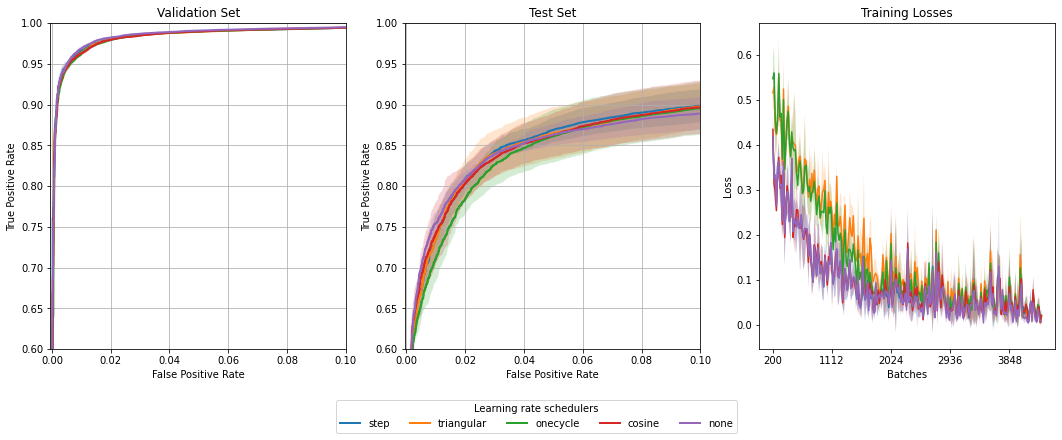

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], tpr_std=tprs_std_val[key], model_name=key, ax=axs[0], ylim=[0.6,1], xlim=[-0.0005, 0.1])
    plot_roc_curve(base_fpr, tprs_mean[key], tpr_std=tprs_std[key], model_name=key, ax=axs[1], ylim=[0.6,1], xlim=[-0.0005, 0.1])

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

plot_losses(RUN_TYPES, ax=axs[2], skip_types=[], start=200)
#axs[2].legend(loc='upper right', title="Learning rate")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')